## Post processing of the one sided diffusor case 

### 1 General variables

In [407]:
# file path
# dont have meanWSS yet
#path = '../test_cases/kOmega-SST_2D/run/resultTransient'
#path = '../test_cases/kOmega-SST_2D/run/resultTransient3.1' # cellLimited Gauss linear 1.0 relaxation p 0.8, time 0.5
#path = '../test_cases/kOmega-SST_2D/run/resultTransient10' # cellLimited Gauss linear 1.0 relaxation p 0.4; U 0.95 , time 0.01, maxCo 0.95, relTol p 0.001
#path = '../test_cases/kOmega-SST_2D/run/resultTransient11' # cellLimited Gauss linear 1.0 relaxation p 0.4; U 0.95 , time 0.01, maxCo 0.95, relTol p 0.001, mesh 3.1
#path = '../test_cases/spalart_allmaras/run/spalart_allmaras_relaxation_p_0.4_euler_mesh3.1/transient' # time 0.01
# path = '../test_cases/kOmega-SST_2D/run/mesh_v2_transient_euler_relaxation_p_0.4/transient'
#path = '../test_cases/kOmega-SST_2D/run/mesh_v3_3_transient/transient'
#path = '../test_cases/kOmega-SST_2D/run/kOmegaSST_a1=0.15/transient' # lastTime 0.01
#path = '../test_cases/kOmega-SST_2D/run/kOmegaSST_a1=0.15/steadyState' # lastTime 6000

# have a meanWSS
#path = '../test_cases/kOmega-SST_2D/run/kOmegaSST_a1=0.25_TransFromBeggining/transient' # lastTime 0.01
path = '../test_cases/kOmega-SST_2D/run/kOmegaSST_a1=0.20_init_steady_2000/transient' # lastTime 0.1
#path = '../test_cases/kOmega-SST_2D/run/kOmegaSST_a1=0.25_init_steady_2000/transient' # lastTime 0.1
#path = '../test_cases/kOmega-SST_2D/run/kOmegaSST_a1=0.25_init_steady_2000_mPimpleIter/transient' # lastTime 0.05
#path = '../test_cases/kOmega-SST_2D/run/kOmegaSST_a1=0.25_init_steady_2000_newSchemes/transient' # lastTime 0.005

# time to which case was solved used for the pressure difference 
last_time = 0.1

# number of iterations at which the wall shear stress is analyzed
time = 0.1



# angle of the ramp
angle = 20

# density of the airflow 
rhoL = 1.225

#### 1.1 Used Libaries

In [408]:
# loading libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 2 Functions

#### 2.1 Function to plot residuals

In [409]:
def residuals():
    # column names 
    colnames = [
        "Time", "U_solver", "Ux_initial", "Ux_final", "Ux_iters",
        "Uy_initial", "Uy_final", "Uy_iters", "U_converged",
        "k_solver", "k_initial", "k_final", "k_iters", "k_converged",
        "omega_solver", "omega_initial", "omega_final", "omega_iters", "omega_converged",
        "p_solver", "p_initial", "p_final", "p_iters", "p_converged"
    ]


    # plotting 
    plt.figure(figsize=(12, 6))
    filepath = str(path) + '/postProcessing/solverInfo/0/solverInfo.dat'
        
        # reading data
    df = pd.read_csv(filepath, sep=r'\s+', skiprows=2, names=colnames)
        
    plt.plot(df["Time"], df["Ux_initial"], label="Ux_initial")
    plt.plot(df["Time"], df["Uy_initial"], label="Uy_initial")
    plt.plot(df["Time"], df["k_initial"], label="k_initial")
    plt.plot(df["Time"], df["p_initial"], label="p_initial")
    plt.plot(df["Time"], df["omega_initial"], label="omega_initial")
        
    plt.xlabel("Time")
    plt.ylabel("Initial residuals (log)")
    plt.title(f"Initial residuals")
    plt.yscale('log')
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.xlim(0, last_time)

    # showing layout
    plt.tight_layout()
    plt.show()

#### 2.2 Function to plot and create tables of the wall shear stress along the lower wall

In [410]:
def process_file(file_path):
    data_pairs = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('#') or not line.strip():
                continue

            parts = line.strip().split()
            if len(parts) >= 9:
                x = float(parts[0])*1000 # in mm

                area = np.array([
                    float(parts[6]),
                    float(parts[7]),
                    float(parts[8])
                ])
                norm = np.linalg.norm(area)
                area_normalized = area / norm if norm != 0 else area
                
                # cross product of the ez and and area normal vektor to get a vector following the wall
                ez = np.array([0, 0, 1])
                cross_prod = np.cross(area_normalized, ez)

                shear = np.array([
                    float(parts[3]),
                    float(parts[4]),
                    float(parts[5])
                ])

                # transformation of the wss vector in the wall following COS
                scalar_product = np.dot(shear, cross_prod)

                # multiplying by density to get [Pa]
                wss = rhoL*scalar_product
                data_pairs.append((x, wss))

    # sorting
    data_pairs.sort(key=lambda pair: pair[0])
    return sorted(data_pairs, key=lambda pair: pair[0])


def plot_wss():
    
    plt.figure(figsize=(10, 5))
    

   
    file_path = (
        str(path) + "/postProcessing/samplesLower/" + str(time) + "/wallShearStress_lowerWall.raw"
    )

    data_pairs = process_file(file_path)
    x_vals = [pair[0] for pair in data_pairs]
    scalar_vals = [pair[1] for pair in data_pairs]
    print(scalar_vals[0])

    plt.plot(x_vals, scalar_vals)
        
    plt.title('wall shear stresses at the lower wall')
    plt.xlabel('global x value in mm ')
    plt.ylabel('wall shear stress in Pa')
    plt.xlim(0, 400)
    plt.ylim(-1.5, 1.5)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


#### 2.2.1 Function to plot and create tables of the mean wall shear stress along the lower wall

In [411]:
def plot_meanWss():
    plt.figure(figsize=(10, 5))
    

   
    file_path = (
        str(path) + "/postProcessing/samplesLower/" + str(time) + "/wallShearStressMean_lowerWall.raw"
    )

    data_pairs = process_file(file_path)
    x_vals = [pair[0] for pair in data_pairs]
    scalar_vals = [pair[1] for pair in data_pairs]

    plt.plot(x_vals, scalar_vals)
        
    plt.title('mean wall shear stresses at the lower wall')
    plt.xlabel('global x value in mm ')
    plt.ylabel('wall shear stress in Pa')
    plt.xlim(0, 400)
    plt.ylim(-1.5, 1.5)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

##### 2.2.2 Function to create tables of the wall shear stress along the lower wall

In [412]:
def interpolate_wss_at_points(x_targets):
    results = {'x': x_targets}

    
    # file path to use the process_file function to calculate the transformed wss
    file_path = (
        str(path) + "/postProcessing/samplesLower/" + str(time) + "/wallShearStress_lowerWall.raw"
    )

    # loading data
    data_pairs = process_file(file_path)
    x_vals = np.array([pair[0] for pair in data_pairs])
    scalar_vals = np.array([pair[1] for pair in data_pairs])

    # linear interpolation 
    interpolated = np.interp(x_targets, x_vals, scalar_vals)

    # adding to table 
    results[f'transient'] = interpolated

    # dataFrame run 
    df = pd.DataFrame(results)
    return df

##### 2.2.3 Function to create tables of the mean wall shear stress along the lower wall

In [413]:
def interpolate_meanWss_at_points(x_targets):
    results = {'x': x_targets}

    
    # file path to use the process_file function to calculate the transformed wss
    file_path = (
        str(path) + "/postProcessing/samplesLower/" + str(time) + "/wallShearStressMean_lowerWall.raw"
    )

    # loading data
    data_pairs = process_file(file_path)
    x_vals = np.array([pair[0] for pair in data_pairs])
    scalar_vals = np.array([pair[1] for pair in data_pairs])

    # linear interpolation 
    interpolated = np.interp(x_targets, x_vals, scalar_vals)

    # adding to table 
    results[f'transient'] = interpolated

    # dataFrame run 
    df = pd.DataFrame(results)
    return df

#### 2.3 Function to plot the wall shear stress along the upper wall 

In [414]:
def wss_upperWall(file_path):
    data_wss_upperWall = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('#') or not line.strip():
                continue

            parts = line.strip().split()
            if len(parts) >= 9:
                x = float(parts[0])

                area = np.array([
                    float(parts[6]),
                    float(parts[7]),
                    float(parts[8])
                ])
                
                wss_x = float(parts[3])
                
                # openFoam wss in m²/s² needs multiplikation with rho to match experiment
                wss = rhoL*wss_x 
                data_wss_upperWall.append((x, wss))

    # sorting
    data_wss_upperWall.sort(key=lambda pair: pair[0])
    return sorted(data_wss_upperWall, key=lambda pair: pair[0])


def plot_wss_upperWall():
    plt.figure(figsize=(10, 5))
        
    # choosing file path
    file_path = (
        str(path) + "/postProcessing/samplesUpper/" + str(time) + "/wallShearStress_upperWall.raw"
    )

    data_wss_upperWall = process_file(file_path)
    x_vals = [pair[0] for pair in data_wss_upperWall]
    scalar_vals = [pair[1] for pair in data_wss_upperWall]

    plt.plot(x_vals, scalar_vals)
        
    plt.title('wall shear stresses at the upper wall')
    plt.xlabel('global x value in mm ')
    plt.ylabel('wall shear stress in Pa')
    #plt.xlim(-0.3, 2)
    #plt.ylim(-1, 0.3)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### 2.4 Function to calculate the pressure difference

In [415]:
def delta_p(file_path):
    data_pairs = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('#') or not line.strip():
                continue

            parts = line.strip().split()

            time = float(parts[0])

            # using the absolute value of p_inlet as delta_p
            delta_p = np.array(abs(float(parts[1])))

            data_pairs.append((time, delta_p))
    return data_pairs

def plot_delta_p():
    plt.figure(figsize=(10, 5))  
  
    file_path = (
        str(path) + "/postProcessing/delta_p:pInlet/0/surfaceFieldValue.dat"
    )

    data_pairs = delta_p(file_path)
    x_vals = [pair[0] for pair in data_pairs]
    scalar_vals = [pair[1] for pair in data_pairs]

    plt.plot(x_vals, scalar_vals)
        
    plt.title('Pressure difference over the diffusor')
    plt.xlabel('time')
    plt.ylabel('absolute value of the pressure in m²/s²')
    plt.xlim(0, last_time)
    #plt.ylim(-0.5, 0.5)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



### 3 Plots and tables 

#### 3.1 Residuals

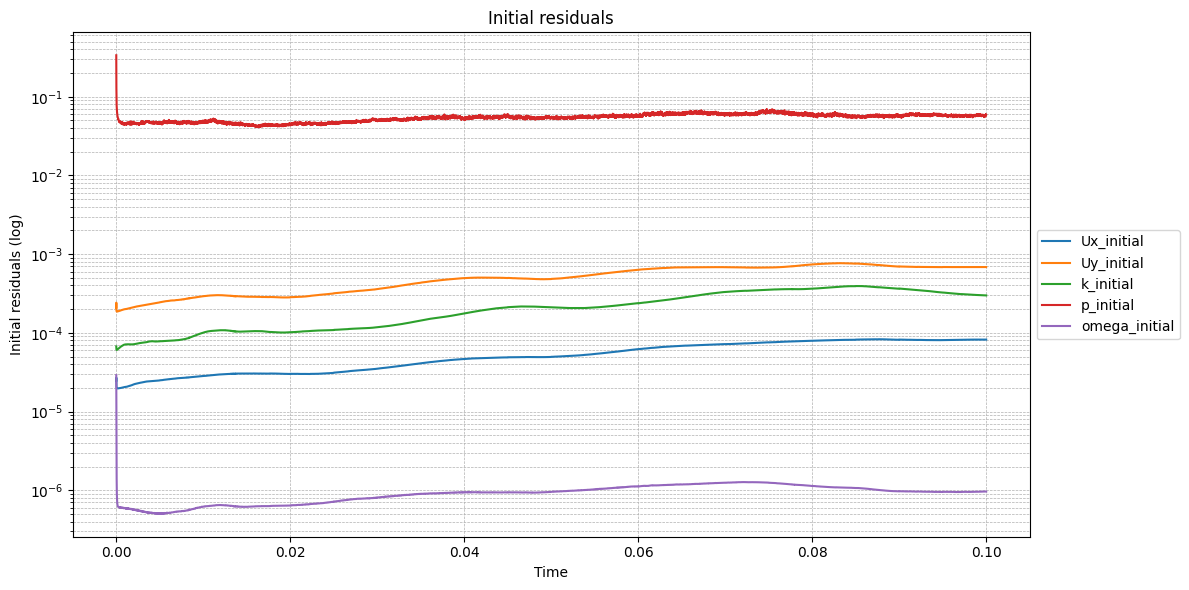

In [416]:
residuals()

#### 3.2 Wall shear stress

##### 3.2.1 Plot of WSS along the lower wall

6.050875250000001


/tmp/ipykernel_1080394/1088988227.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


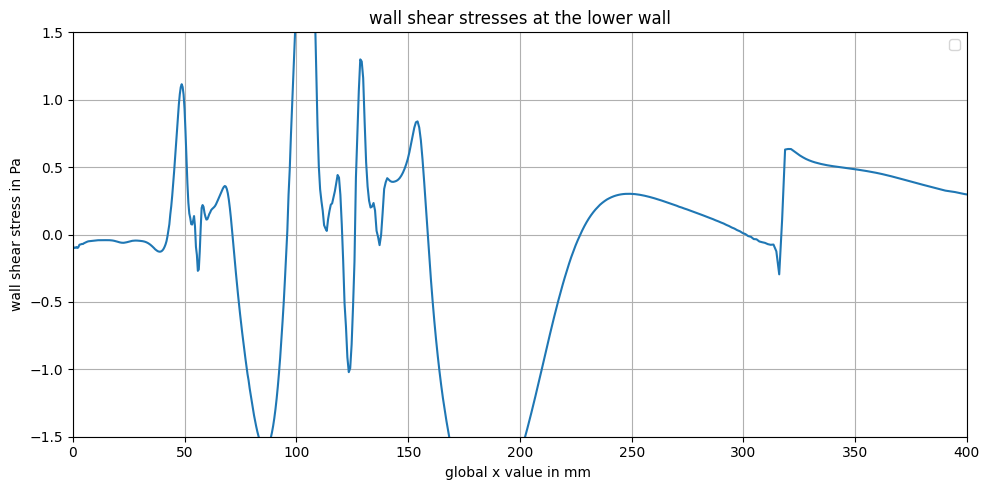

In [417]:
plot_wss()

##### 3.2.1 Plot of mean WSS along the lower wall

/tmp/ipykernel_1080394/2136107347.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


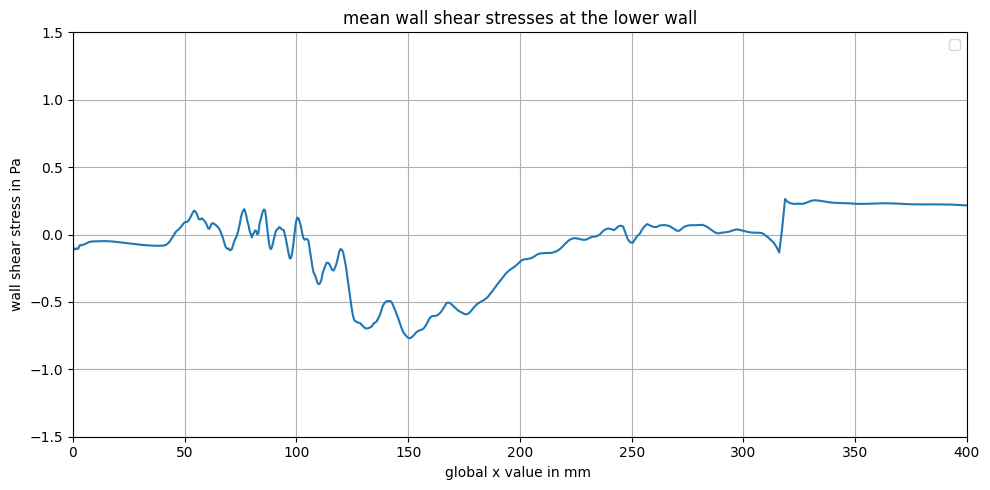

In [418]:
plot_meanWss()

##### 3.2.2 Table of the WSS at the lower wall at certain points in the global COS

In [419]:
# desired x values 
x_targets = np.array([82, 122, 162, 202, 242, 282, 386])

# executing functions for interpolation and table 
interpolation_table = interpolate_wss_at_points(x_targets)
print(interpolation_table.to_string(index=False))

  x  transient
 82  -1.422557
122  -0.634756
162  -0.692537
202  -1.521256
242   0.283811
282   0.141960
386   0.344120


##### 3.2.3 Table of the mean WSS at the lower wall at certain points in the global COS

In [420]:
# desired x values 
x_targets = np.array([82, 122, 162, 202, 242, 282, 386])

# executing functions for interpolation and table 
interpolation_table = interpolate_meanWss_at_points(x_targets)
print(interpolation_table.to_string(index=False))

  x  transient
 82   0.026926
122  -0.223197
162  -0.604247
202  -0.184492
242   0.032413
282   0.069731
386   0.223540


##### 3.2.4 Table of the WSS at the lower wall at certain points in the ramp COS

In [421]:
# values of x in transformed from the global COS to the COS of the ramp
ramp_x = np.cos(np.radians(angle))*x_targets
ramp_x_2f = np.round(ramp_x, 2)
# Interpolation ausführen und anzeigen
interpolation_table2 = interpolate_wss_at_points(ramp_x_2f)
print(interpolation_table2.to_string(index=False))

     x  transient
 77.05  -0.901861
114.64   0.159167
152.23   0.750196
189.82  -2.048527
227.41   0.013380
264.99   0.243201
362.72   0.446065


##### 3.2.5 Table of the mean WSS at the lower wall at certain points in the ramp COS

In [422]:
# values of x in transformed from the global COS to the COS of the ramp
# defined in 3.2.4
# Interpolation ausführen und anzeigen
interpolation_table2 = interpolate_meanWss_at_points(ramp_x_2f)
print(interpolation_table2.to_string(index=False))

     x  transient
 77.05   0.171985
114.64  -0.218048
152.23  -0.752388
189.82  -0.371556
227.41  -0.036289
264.99   0.069327
362.72   0.231661


#### 3.5 Plot of the wall shear stress along the upper wall (sample doesnt exist jet)

/tmp/ipykernel_1080394/3662908199.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


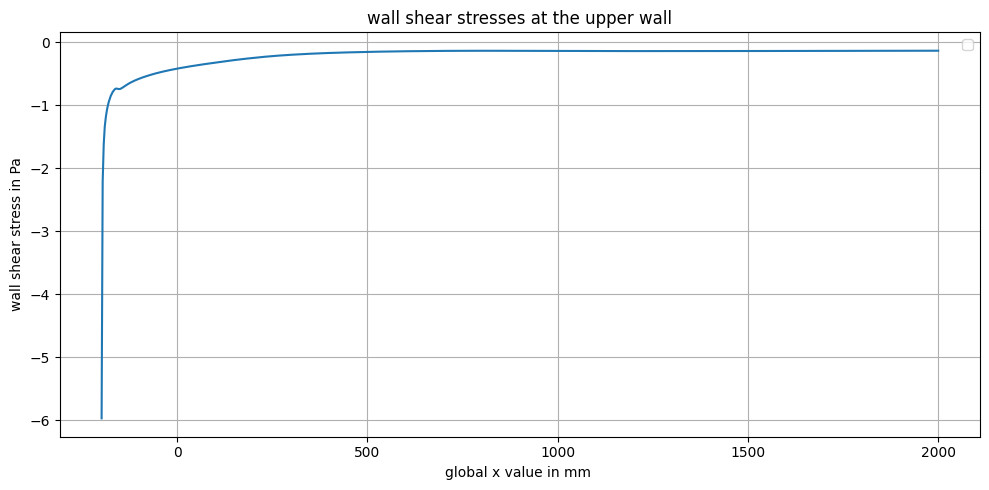

In [423]:
plot_wss_upperWall()

#### 3.6 Plot of the pressure differnce over the diffusor

/tmp/ipykernel_1080394/152857264.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


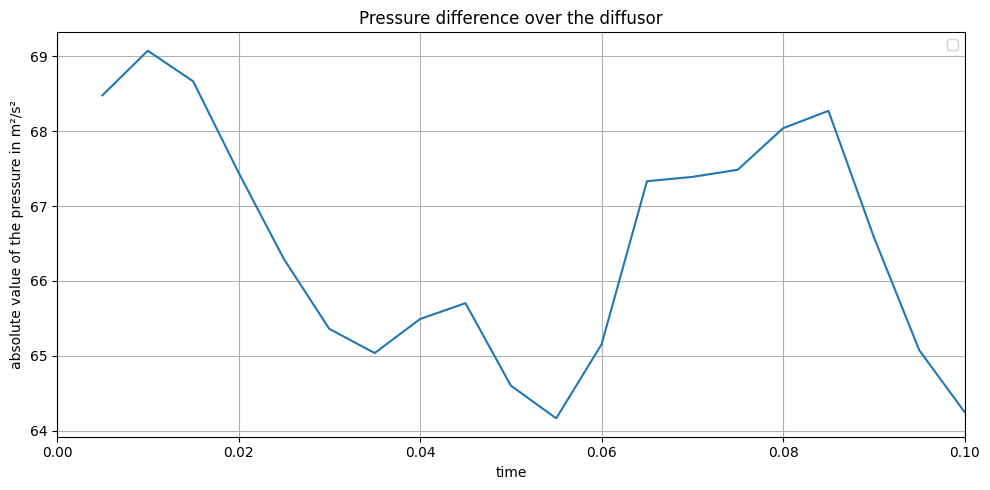

In [424]:
plot_delta_p()